In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [1]:
pip install gym==0.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.5/734.5 kB 48.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.25.2-py3-none-any.whl size=852305 sha256=f7c065c9efcf561986d09f11b9b167da2622dc1f9c206a0755877aa4d1106381
  Stored in directory: /root/.cache/pip/wheels/05/4d/6c/d0ef0db36695ce032fe20099e3149d8db85cf36656176ff745
Successfully built gym
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import sys
from os.path import isfile
import gym
import keras
from keras.layers import Dense
from keras.layers.core import Flatten
import gym.spaces
import cv2
import numpy as np
import collections
import torch
import torch.nn as nn        
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
import collections
import matplotlib.pyplot as plt



/usr/local/lib/python3.9/dist-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:39: DeprecationWarning: HAMMING is deprecat

In [3]:
pip install "gym[atari, accept-rom-license]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=446447 sha256=7502ffe064fc204c4caf4acc07a2b73edd3dd5589e7d57a7417797335bea3e21
  Stored in directory: /root/.cache/pip/wheels/2b/03/e4/8b662e95b85786a03898fca125d5a9e3fe49337b1eba8fddd2
Successfully built AutoROM.accept-rom-license
Note: you may need to restart the kernel to use updated packages.


In [3]:
test_env = gym.make("PongNoFrameskip-v4")
print(test_env.action_space.n)

6


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


#We will be using wrappers. In the deepmind paper
#it is implemented using transformations in deepminds paper
HERE we will be using the repository called baslines which is provided by openai
the link is here:
[link text](
https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


#IN The block below the class FireResetEnv is used as some atari games like
#Pong require a user to press the FIRE button to start the game. 
# So we imported the wrapper for that from the openai/baselines


In [5]:
print("Some Atari games have a flickering effect" )
print("which is due to the platform’s limitation. For the naked eye, such fast changes are not visible, but they can confuse a Neural Network.")

Some Atari games have a flickering effect
which is due to the platform’s limitation. For the naked eye, such fast changes are not visible, but they can confuse a Neural Network.


In [4]:
MEAN_REWARD_BOUND = 19.0           

gamma = 0.99                   
batch_size = 32                
replay_size = 10000            
learning_rate = 1e-4           
sync_target_frames = 1000      
replay_start_size = 10000      

eps_start=1.0
eps_decay=.999985
eps_min=0.02

In [5]:


class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


#cropping non-relevant parts of the image and then scaling down to 84,84,1 as mentioned in the deepmind paper
class resizing_image(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(resizing_image, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return resizing_image.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            image = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            image = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        image = image[:, :, 0] * 0.299 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.114
        resized_screen = cv2.resize(image, (84, 110), interpolation=cv2.INTER_AREA)
        x_train = resized_screen[18:102, :]
        x_train = np.reshape(x_train, [84, 84, 1])
        return x_train.astype(np.uint8)

list5={}
#Now we stack 4 frames together to pass it to the neural network as using only one frame tells the neural network nothing

class stack_frame(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(stack_frame, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0), old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


#HWC (height, width, channel) to the CHW (channel, height, width) format required by PyTorch:
list1=[]

class toPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(toPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = resizing_image(env)
    env = toPyTorch(env)
    env = stack_frame(env, 4)
    return ScaledFloatFrame(env)

In [6]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self.get_conv_output(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def get_conv_output(self, shape):
        output = self.conv(torch.zeros(1, *shape))
        return int(np.prod(output.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [7]:
playing_env = make_env("PongNoFrameskip-v4")
test_net = DQN(playing_env.observation_space.shape, playing_env.action_space.n)


In [8]:
exp = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, exp):
        self.buffer.append(exp)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

In [9]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0):

        done_reward = None
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        expe = exp(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(expe)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


898:  1 Number of games playes, The mean reward -21.000, (epsilon 0.99)
Best mean reward updated -21.000
1925:  2 Number of games playes, The mean reward -20.500, (epsilon 0.97)
Best mean reward updated -20.500
2844:  3 Number of games playes, The mean reward -20.000, (epsilon 0.96)
Best mean reward updated -20.000
3950:  4 Number of games playes, The mean reward -20.250, (epsilon 0.94)
4954:  5 Number of games playes, The mean reward -20.000, (epsilon 0.93)
5999:  6 Number of games playes, The mean reward -19.833, (epsilon 0.91)
Best mean reward updated -19.833
6946:  7 Number of games playes, The mean reward -19.857, (epsilon 0.90)
7871:  8 Number of games playes, The mean reward -19.875, (epsilon 0.89)
8652:  9 Number of games playes, The mean reward -20.000, (epsilon 0.88)
9568:  10 Number of games playes, The mean reward -20.000, (epsilon 0.87)


/tmp/ipykernel_128/1608347790.py:65: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1581.)
  next_state_values[done_mask] = 0.0


10590:  11 Number of games playes, The mean reward -20.000, (epsilon 0.85)
11617:  12 Number of games playes, The mean reward -19.833, (epsilon 0.84)
12610:  13 Number of games playes, The mean reward -19.769, (epsilon 0.83)
Best mean reward updated -19.769
13544:  14 Number of games playes, The mean reward -19.786, (epsilon 0.82)
14445:  15 Number of games playes, The mean reward -19.800, (epsilon 0.81)
15285:  16 Number of games playes, The mean reward -19.812, (epsilon 0.80)
16288:  17 Number of games playes, The mean reward -19.882, (epsilon 0.78)
17188:  18 Number of games playes, The mean reward -19.889, (epsilon 0.77)
18028:  19 Number of games playes, The mean reward -19.895, (epsilon 0.76)
18809:  20 Number of games playes, The mean reward -19.950, (epsilon 0.75)
19772:  21 Number of games playes, The mean reward -19.952, (epsilon 0.74)
20535:  22 Number of games playes, The mean reward -20.000, (epsilon 0.73)
21464:  23 Number of games playes, The mean reward -20.043, (epsilo

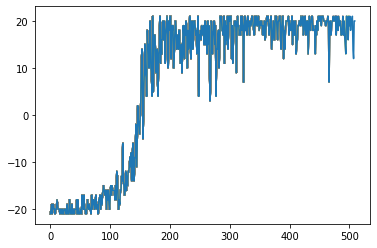

In [10]:
env = make_env("PongNoFrameskip-v4")
env_name_print = "PongNoFrameskip-v4"

net = DQN(env.observation_space.shape, env.action_space.n)
target_net = DQN(env.observation_space.shape, env.action_space.n)
 
buffer = ExperienceReplay(replay_size)
agent = Agent(env, buffer)

epsilon = eps_start
eps_track = []
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
total_rewards = []
frame_idx = 0  

best_mean_reward = None
i=0
j=10
while True:
        
        frame_idx += 1
        epsilon = max(epsilon*eps_decay, eps_min)
        eps_track.append(epsilon)
                   
        reward = agent.play_step(net, epsilon)
        if reward is not None:
            i+=1
            total_rewards.append(reward)
            if(i%10==0):
              plt.plot(total_rewards, label = "Total Scores")
              plt.plot(epsilon, label = "Epsilon decay")
              #plt.imshow(total_rewards)
              #plt.imshow(eps_track)
            mean_reward = np.mean(total_rewards[-100:])

            print("%d:  %d Number of games playes, The mean reward %.3f, (epsilon %.2f)" % (
                frame_idx, len(total_rewards), mean_reward, epsilon))

            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), env_name_print + "-best.dat")
                best_mean_reward = mean_reward
                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f" % (best_mean_reward))

            if mean_reward > MEAN_REWARD_BOUND:
                print("we beat the human in %d frames!" % frame_idx)
                break

        if len(buffer) < replay_start_size:
            continue

        batch = buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = batch

        states_v = torch.tensor(states)
        next_states_v = torch.tensor(next_states)
        actions_v = torch.tensor(actions)
        rewards_v = torch.tensor(rewards)
        done_mask = torch.ByteTensor(dones)

        state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

        next_state_values = target_net(next_states_v).max(1)[0]

        next_state_values[done_mask] = 0.0

        next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * gamma + rewards_v

        loss_t = nn.MSELoss()(state_action_values, expected_state_action_values)

        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        if frame_idx % sync_target_frames == 0:
            target_net.load_state_dict(net.state_dict())

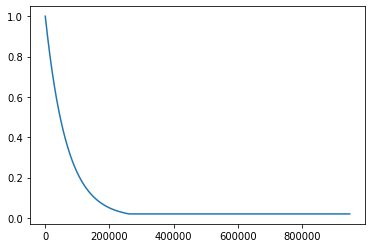

In [12]:
plt.plot(eps_track, label = "Epsilon decay")